# **Определение авторов художественных произведений по текстовым фрагментам с помощью машинного обучения.**

Как известно, у каждого автора, будь то Лев Толстой, Эрнест Хемингуэй или Стивен Кинг, присутствует свой стиль письма, включающий в себя фирменную манеру использования определенных слов, что делает их произведеня уникальными и узнаваемыми. Давайте попробуем воспользоваться этим фактом, чтобы определить авторов по цитатам из их прозведений.

Для эксперимента я взял по три произведения трех известных англоязычных авторов: Артура Конан Дойля ("Затерянный мир", "Собака Баскервилей", "Приключения бригадира Жерара"), Агаты Кристи ("Человек в коричневом костюме", "Загадочное происшествие в Стайлзе", "Пуаро ведет следствие") и Уилки Коллинза ("Мертвый секрет", "Без названия", "Муж и жена"). Важно, что все эти произведения были написаны приблизительно в одно время. Из каждого из этих произведений я взял приблизительно по 550 предложений.

Итак, приступим к разработке модели машинного обучения на Python. В работе нам понадобятся следующие библиотеки:

- scikit-learn – свободно распространяемая библиотека на python, содержащая реализации различных методов 
машинного обучения,
- nltk – пакет библиотек для символьной и статистической обработки естественного языка,
- matplotlib – библиотека, содержащая набор инструментов для визуализации данных,
- Seaborn — популярная библиотека готовых шаблонов для статистической визуализации,
- а также numpy, pandas и т.п.

In [1]:
# Импортируем нужные библиотеки
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, phrases, ldamodel, CoherenceModel
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim.corpora as corpora
from pprint import pprint
from collections import Counter


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Входные данные (предложения) я сохранил в виде csv файла - это общепринятый подход.
# Данные из csv файла загружаем с помощью pandas в объект типа DataFrame, который состоит из строк и столбцов.
# sep="," означает, что в качестве разделителя в csv файле используется запятая, encoding='Latin-1' - кодировка.
url = 'https://raw.githubusercontent.com/miksadikov/author-identification-with-nlp/master/train-dataset.csv'
data_df = pd.read_csv(url, sep=",", encoding='Latin-1')
data_df.head()

,id,text,author
0,id1817,The dear little ear which I had kissed so often.,ACD
1,id4103,"Psychoanalysis, what?",ACR
2,id1607,"But I stood as a debonair soldier should, and ...",ACD
3,id6793,you dont look at him with my impartial eyes.,WKL
4,id6532,Almost at the same moment Miss Garth entered t...,WKL


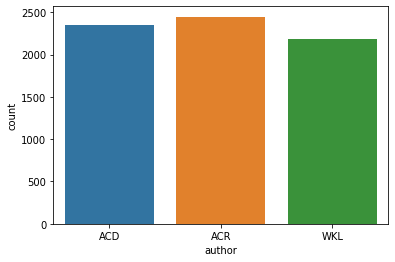

In [6]:
sns.countplot(data_df['author'])

In [7]:
# удаляем столбец id в DataFrame, там содержится порядковый номер предложени в датасете - он нам не понадобится
data_df = data_df.drop(columns = ['id'], axis=1)
data_df.head()

,text,author
0,The dear little ear which I had kissed so often.,ACD
1,"Psychoanalysis, what?",ACR
2,"But I stood as a debonair soldier should, and ...",ACD
3,you dont look at him with my impartial eyes.,WKL
4,Almost at the same moment Miss Garth entered t...,WKL


In [8]:
# Выполняем предобработку - удаляем знаки препинания, переводим заглавные буквы в прописные:
data_df['text_processed'] = data_df['text'].map(lambda x: re.sub('[,\.!?]','',x))
data_df['text_processed'] = data_df['text_processed'].map(lambda x:x.lower())
print(data_df['text_processed'].head())

0      the dear little ear which i had kissed so often
1                                  psychoanalysis what
2    but i stood as a debonair soldier should and i...
3         you dont look at him with my impartial eyes
4    almost at the same moment miss garth entered t...
Name: text_processed, dtype: object


In [9]:
# Удаляем стоп-слова
# Стоп-слова обычно представляют собой артикли (a, an, the), предлоги и другие часто встречающиеся
# слова, не содержащие ключевой или необходимой информации.
stopWords = stopwords.words('english')
def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
data_df['text_processed'] = [removeStopWords(stopWords,x) for x in data_df['text_processed']]
longText = ','.join(list(data_df['text_processed'].values))

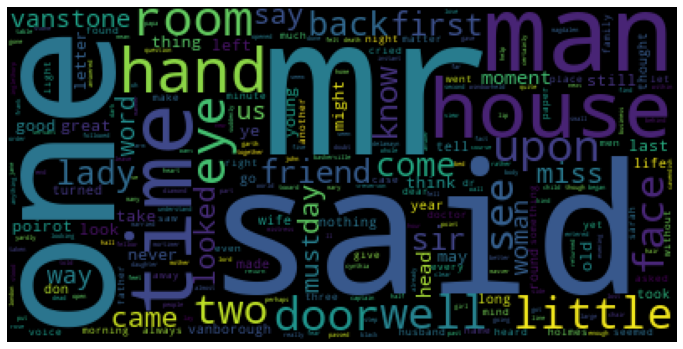

In [10]:
# Отобразим облако слов
wordcloud = WordCloud(background_color="black",
                      max_words= 600,
                      contour_width = 10,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
fig = plt.figure(1, figsize = (12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

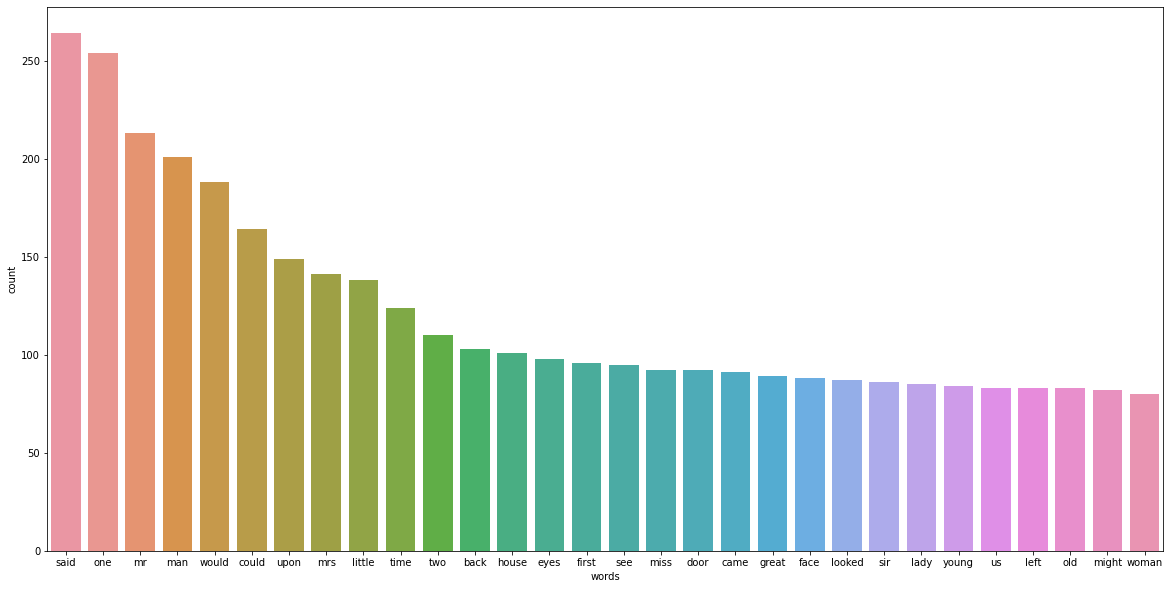

In [11]:
# отобразим на графике, сколько раз встречаются в текстах 30 самых частоупотребимых слов:
fig = plt.figure(1, figsize = (20,10))
split_it = longText.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

In [12]:
# Выполняем токенизацию (разбивку на отдельные слова)
# Ниже последовательно отображены результаты обработки
nltk.download("punkt")
# word_tokenize 
data_df["tokenized"] = data_df["text_processed"].apply(lambda x: nltk.word_tokenize(x))
data_df["tokenized"] = data_df["tokenized"].apply(lambda words: [word for word in words if word.isalnum()])
data_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,author,text_processed,tokenized
0,The dear little ear which I had kissed so often.,ACD,dear little ear kissed often,"[dear, little, ear, kissed, often]"
1,"Psychoanalysis, what?",ACR,psychoanalysis,[psychoanalysis]
2,"But I stood as a debonair soldier should, and ...",ACD,stood debonair soldier could reflect much cred...,"[stood, debonair, soldier, could, reflect, muc..."
3,you dont look at him with my impartial eyes.,WKL,dont look impartial eyes,"[look, impartial, eyes]"
4,Almost at the same moment Miss Garth entered t...,WKL,almost moment miss garth entered hall morning-...,"[almost, moment, miss, garth, entered, hall]"
...,...,...,...,...
6978,"Magdalen, who was accustomed to pass the morni...",WKL,magdalen accustomed pass morning piano wandere...,"[magdalen, accustomed, pass, morning, piano, w..."
6979,In each case the outside porter will send for ...,ACD,case outside porter send hall porter also give...,"[case, outside, porter, send, hall, porter, al..."
6980,Here is a copy of the _Times_.,ACD,copy _times_,[copy]
6981,"Mrs. Treverton held up her hand, as a sign tha...",WKL,mrs treverton held hand sign another order give,"[mrs, treverton, held, hand, sign, another, or..."


In [13]:
# Метки классов у нас представлеты в текстовом виде (ACD, ACR, WKL), нужно перевести их в цифровой вид:
from sklearn.preprocessing import LabelEncoder
y = data_df['author']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [14]:
# Выполняем лемматизацию, все слова в тексте приводятся к нормальной форме (единственное число, именительный падеж).
# Ниже последовательно отображены результаты обработки
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
def word_lemmatizer(text):
  lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
  return lem_text
data_df["lemmatized"] = data_df["tokenized"].apply(lambda x: word_lemmatizer(x))
data_df["lemmatize_joined"] = data_df["lemmatized"].apply(lambda x: ' '.join(x))
pd.set_option('display.max_colwidth', 100)
data_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,author,text_processed,tokenized,lemmatized,lemmatize_joined
0,The dear little ear which I had kissed so often.,ACD,dear little ear kissed often,"[dear, little, ear, kissed, often]","[dear, little, ear, kiss, often]",dear little ear kiss often
1,"Psychoanalysis, what?",ACR,psychoanalysis,[psychoanalysis],[psychoanalysis],psychoanalysis
2,"But I stood as a debonair soldier should, and I could not but reflect how much credit I was brin...",ACD,stood debonair soldier could reflect much credit bringing upon hussars conflans dignity bearing,"[stood, debonair, soldier, could, reflect, much, credit, bringing, upon, hussars, conflans, dign...","[stand, debonair, soldier, could, reflect, much, credit, bring, upon, hussars, conflans, dignity...",stand debonair soldier could reflect much credit bring upon hussars conflans dignity bear
3,you dont look at him with my impartial eyes.,WKL,dont look impartial eyes,"[look, impartial, eyes]","[look, impartial, eye]",look impartial eye
4,Almost at the same moment Miss Garth entered the hall from the morning-room.,WKL,almost moment miss garth entered hall morning-room,"[almost, moment, miss, garth, entered, hall]","[almost, moment, miss, garth, enter, hall]",almost moment miss garth enter hall


In [15]:
tokens = data_df["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))
tokens

0                                                                          [dear, little, ear, kiss, often]
1                                                                                          [psychoanalysis]
2       [stand, debonair, soldier, could, reflect, much, credit, bring, upon, hussars, conflans, dignity...
3                                                                                    [look, impartial, eye]
4                                                                [almost, moment, miss, garth, enter, hall]
                                                       ...                                                 
6978    [magdalen, accustom, pass, morning, piano, wander, restlessly, staircases, passages, doors, glim...
6979                                         [case, outside, porter, send, hall, porter, also, give, shill]
6980                                                                                                 [copy]
6981                        

In [16]:
X =  data_df['text']


In [17]:
# Объединяем всю предобработку в одну ф-цию
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatiser = WordNetLemmatizer()# Defining a module for Text Processing

def text_process(tex):
    # 1. Removal of Punctuation Marks 
    nopunct=[char for char in tex if char not in string.punctuation]
    nopunct=''.join(nopunct)
    # 2. Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '
    # 3. Removal of Stopwords
    return [word for word in a.split() if word.lower() not 
            in stopwords.words('english')]

In [18]:
# Большинство математических моделей работают в векторных пространствах больших размерностей, поэтому необходимо
# перевести наши текстовые данные в числа и отобразить в векторном пространстве. 
# Bag of words (BOW, «Мешок слов»): это одна из самых простых методик векторизации текста. 
# В логике BOW два предложения могут называться одинаковыми, если содержат один и тот же набор слов.

from sklearn.feature_extraction.text import CountVectorizer
# Разбиваем наш датасет на тренировочные и тестовые наборы (80%->Training and 20%->Test)
from sklearn.model_selection import train_test_split
# defining the bag-of-words transformer on the text-processed corpus 
# i.e., text_process() declared in II is executed...
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1234)
# transforming into Bag-of-Words and hence textual data to numeric..
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_train)

# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train) # Данные для обучения
text_bow_test=bow_transformer.transform(X_test) # тестовые данные

In [19]:
# Мы будем испольовать полиноминальный наивный байесовский классификатор
# Достоинствами наивного байесовского классификатора являются нечувствительность к размерам обучающей выборки, 
# высокая скорость обучения и устойчивость к так называемому переобучению (overfitting — явление, при котором 
# алгоритм очень хорошо работает на тренировочной выборке и плохо на тестовой)
# Байесовский классификатор представляет документ как набор слов, вероятности которых условно не зависят 
# друг от друга. Другими словами, этот алгоритм предполагает, что наличие какого-либо признака
# в классе не связано с наличием какого-либо другого признака. 
# В связи с таким допущением алгоритм называется «наивным».

from sklearn.naive_bayes import MultinomialNB
# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()
# Обучаем нашу модель...
model = model.fit(text_bow_train, y_train)

In [20]:
# Предсказание на тренировочных данных:
model.score(text_bow_train, y_train)

0.870390261367705

In [21]:
# Предсказание на тестовых данных:
model.score(text_bow_test, y_test)

0.7050823192555477

In [22]:
# Посмотрим внимательнее на наши результаты:
from sklearn.metrics import classification_report
 
predictions = model.predict(text_bow_test)
print(classification_report(y_test,predictions))
# Precision - точность системы в пределах класса (автора), доля предложений действительно принадлежащих 
# данному автору относительно всех предложений, которые модель отнесла к этому автору
# Recall - полнота системы, доля найденных классфикатором предложений, принадлежащих определенному автору, 
# относительно всех предложений этого автора в тестовой выборке.
# f1-score - F-мера представляет собой гармоническое среднее между точностью и полнотой.
# F-мера = 2 * Точность * Полнота / (Точность + Полнота)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       451
           1       0.69      0.70      0.69       495
           2       0.72      0.72      0.72       451

    accuracy                           0.71      1397
   macro avg       0.71      0.71      0.71      1397
weighted avg       0.71      0.71      0.71      1397



In [23]:
# Теперь возьмем датасет с предложениями, которые модель "еще не видела" (14 предложений из этих же произведений)
url = 'https://raw.githubusercontent.com/miksadikov/author-identification-with-nlp/master/test-sample.csv'
data_df = pd.read_csv(url, sep=",", encoding='Latin-1')
data_df.head()

,id,text,author
0,id1590,"There are many hundred such in this strange city, any one of which has rooms which would grace t...",ACD
1,id1363,We must see what further cards we have in our hands and play them with decision.,ACD
2,id6902,Mamma shakes her head; and Miss Garth looks daggers; and Norahs as sulky as usualbut if you sa...,WKL
3,id3871,"Then she heard that Mary Marvell, whom she knew to be her enemy, had been here, and she changed ...",ACR
4,id2370,"Jeanne, the dresser, ministered to her mistress, talking incessantly and pouring out a stream of...",ACR


In [24]:
S =  data_df['text']

In [25]:
text_bow_sample=bow_transformer.transform(S)

In [26]:
predictions = model.predict(text_bow_sample)

In [27]:
# в переменной predictions мы получили результат предсказания в виде 0, 0, 1, 2, 0 ...
# Это не очень наглядно, поэтому и исходные данные и результат предсказания переведем в текстовый вид:
list1 = list(data_df['author'].values)
print(list1)
# Наши исходные данные - авторы 14 отрывков (предложений):

['ACD', 'ACD', 'WKL', 'ACR', 'ACR', 'ACD', 'WKL', 'ACR', 'ACR', 'ACR', 'WKL', 'ACD', 'ACD', 'ACD']


In [28]:
# Переведем результат распознавания (классификации) в текстовый вид:
list2 = []
for p in predictions:
    if p == 0:
        list2.append('ACD')
    if p == 1:
        list2.append('ACR')
    if p == 2:
        list2.append('WKL')
    
print(list2)
# Результат предсказания - авторы 14 отрывков (предложений):

['ACD', 'WKL', 'WKL', 'ACR', 'WKL', 'ACD', 'WKL', 'ACR', 'ACR', 'ACD', 'WKL', 'ACD', 'ACD', 'ACR']


Как видим, результат 10 верных из 14